En este Notebook se simula la propagación de la envolvente de un campo electrico en una fibra altamente no lineal. Para la simulación se tienen en cuenta las siguientes aproximaciones:


- El campo electrico es quasimonocromatico y tiene una polarización fija, esto es:

$$\mathbf{E}(\mathbf{r},t)=\frac{\hat{x}}{2} \left(E(\mathbf{r},t) \exp(-i\omega_{0}t)+c.c \right)$$

Con $\Delta \omega \ll \omega_{0}$.

- Los cambios en el indice de refracción son pequeños (esto es necesario para hacer teoria de perturubaciones)

- Area efectiva independiente de la frecuencia.

$$\frac{\partial \tilde{{A}'}}{\partial z}=i\frac{\gamma \omega}{\omega_{0}}\text{exp}(-Lz)\mathfrak{F}\left \{ \bar{A}(z,T)\left[(1-f_{R})|\bar{A}(z,{T}')|^2+\Delta t \mathfrak{F}^{-1}\left \{ \mathfrak{F} (h_{R}(T))\mathfrak{F}(|\bar{A}(z,{T})|^2\right]\right \}\right \}   \hspace{0.5cm} (1)$$

 La función R(T) se conoce como  Raman response function, debe incluir contribuciones nucleares y electronicas (Agrawal), esto es $R(t)=(1-f_R)\delta(t)+f_R h_{R}(t)$, donde  $f_R$ representa la contribucion a la respuesta retardada de Raman y la forma de $h_R$ es dada por la vibración de las moleculas$. Escribir la función de respuesta Raman de esta forma impone que las contribuciones electronicas sean instanteas.
 3

 
 
# Raman Responde function
 
Dos propuestas presenta el libro para aproximar la función R(T) en la fibra de Silicio:

1. $$h_{R}(t)=(\tau_1^{-2}+\tau_2^{-2})\tau_1 \text{exp}(-t/\tau_2)\text{sin}(t/\tau_1) \hspace{0.5cm} (2)$$

Con $\tau_1=12.2$ $fs$, $\tau_2=32$ $fs$  y $f_R=0.18$


2. $$h^{new}_{R}(t)=(1-f_b)h_{R}(t)+ f_b(2\tau_b-t)/\tau_b^2  \text{exp}(-t/\tau_b) \hspace{0.5cm} (3)$$

Con $\tau_b=96$ $fs$, $f_b=0.21$ 

# Librerias

In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import math
from scipy.integrate import solve_ivp
import pandas as pd


%matplotlib inline 

#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.style.use('bmh')

Se intentara simular el efecto sobre un pulso de HNLF de thorlabs https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=13874. En nuestro caso, se tiene la fibra HN1550P, la cuál tiene los siguientes parametros:

- Nonlinear coeffient: $\gamma=10.8$ $W^{-1} km^{-1}$
- Effective area: $A_{eff}=12.4$ $\mu m^{2}$
- Dispersion: $D=1$ $ps/(nm \cdot km)$
- Dispersion slope: $\frac{\mathrm{d} D }{\mathrm{d} \lambda}= 0.006$  $ps/(nm^2\cdot km)$
- Mean power: $10$ $mW$
- Pulse width: $200$ $fs$
- Repetition rate: $100$ $MHz$
- Atenuation < $0.9$ $dB/km$

Estos parametros son dados para una longitud de onda de 1550 nm. Los coeficientes de dispersión:

$$\beta_{2}=-\frac{\lambda^2}{2 \pi c} D$$

$$\beta_{3}=\left (\frac{\lambda^2}{2 \pi c}\right)^{2} \left(\frac{2D}{\lambda}+ \frac{\mathrm{d} D }{\mathrm{d} \lambda}\right)$$

In [2]:
n = 2**13    # number of grid points
L = 12.5e-12 # width of time window [s]     
c = 299792458;            #speed of light [m/s]
wavelength=1550e-9      #reference wavelength [m]
w0 = (2*np.pi*c)/wavelength  #reference frequency [Hz]
dt = L/n
T =  np.arange(-n/2,n/2,1)*dt #  time grid
nu=1e6 #Repetition rate (Hz)
t0 =200e-15       # duration of input [s]
power = 10e-3/(nu*t0)        #peak power of input [W]
A = np.sqrt(power)*1/np.cosh(T/t0)**2 # input field [W^(1/2)]
length = 1             #ibre length [m]
#betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]

D=1e-12*1e9*1e-3 #Dispersion
dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope

beta2=-wavelength**2/(2*np.pi*c)*D
beta3=(wavelength**2/(2*np.pi*c))**2*(2*D/wavelength+dD)
betas=[beta2,beta3]

gamma = 10.8*1e-3    #nonlinear coefficient [1/W/m]

loss = 0.9e-3/4.343        #loss [1/m]
#Raman response
fr = 0.18                  # fractional Raman contribution
tau1 = 12.2e-15; tau2 = 32e-15;
#fb=0 ; taub=96e-12  #fb=0.21 ; taub=96e-12 # Response function modified

RT=(tau1**2+tau2**2)/(tau1*tau2**2)*np.exp(-T/tau2)*np.sin(T/tau1)#+fb*(2*taub-T)/taub**2*np.exp(-T/taub)# Response function

RT[T<0]=0

hr=RT/np.trapz(RT, T)

fw =np.fft.ifft((A))




In [3]:
print('The nonlinear-index is: ',gamma*c*12.4e-12/w0)

The nonlinear-index is:  3.303674646724328e-20


Text(0.5, 1.0, 'Perfil temporal inicial del haz incidente')

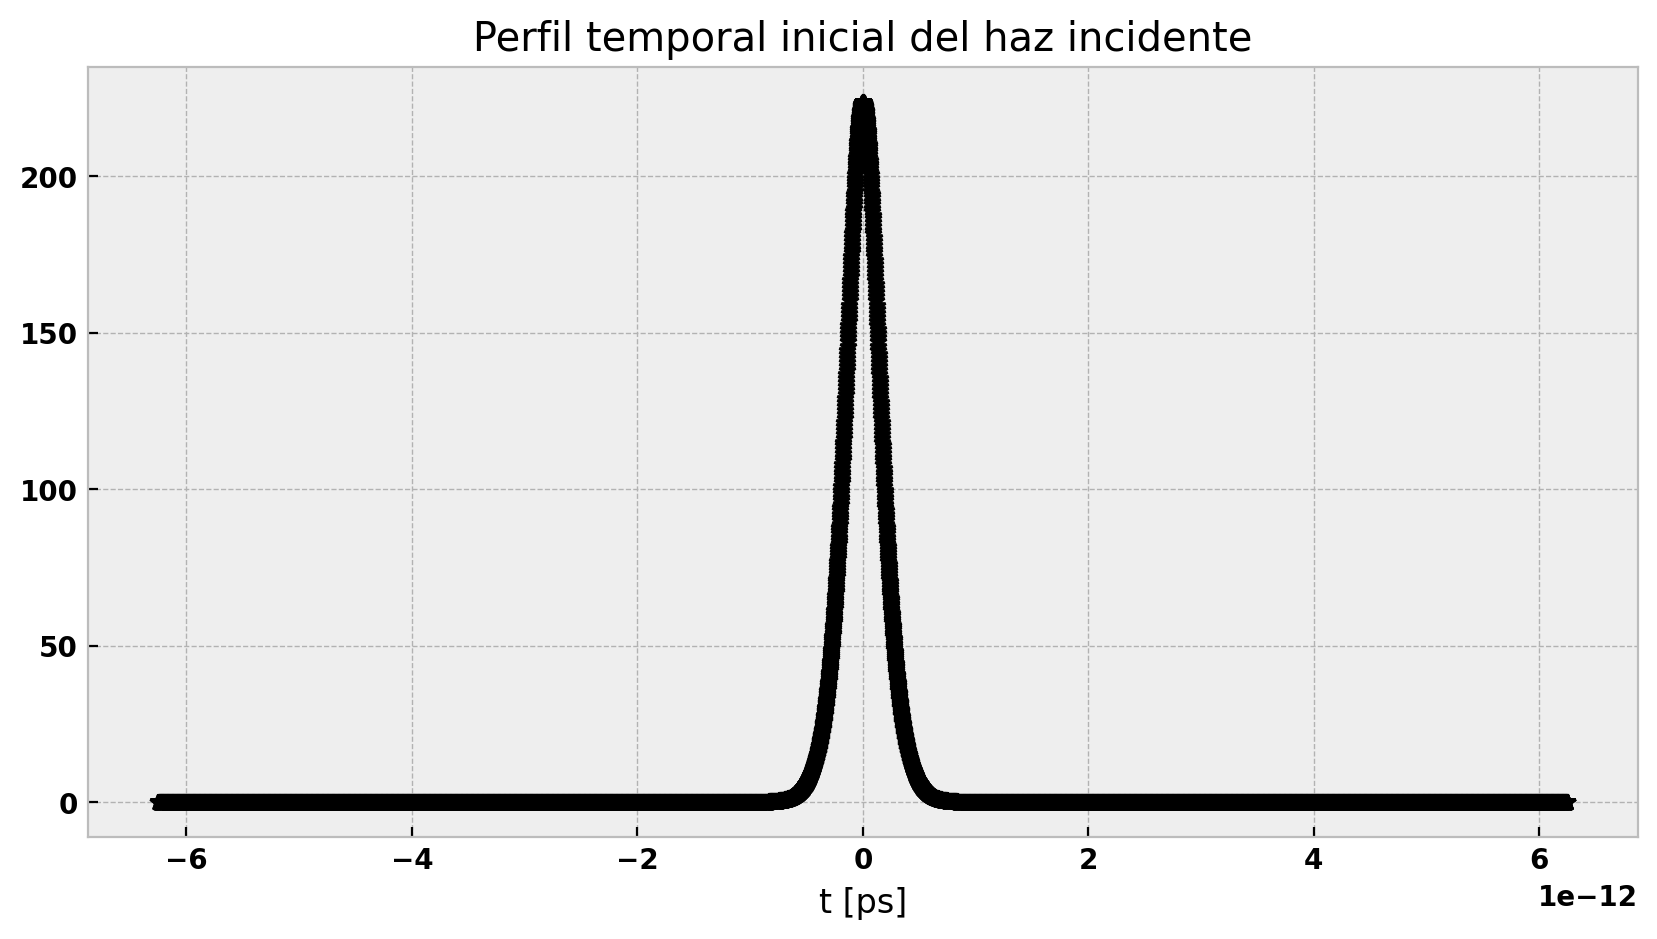

In [4]:
#w = 2*np.pi*np.arange(-1/(2*dt),1/(2*dt),1/(dt*T.size)) #Dominio de la transformada rapida
#Transformada de Fourier Computacional y analitica

f = plt.figure(figsize=(10, 5),dpi=200)
plt.subplot( 1,1, 1)
plt.plot(T,A,color='black',marker='*')
#plt.plot(T,np.fft.fftshift(np.fft.fft(np.fft.fftshift(fw)))/dT,'--b')
plt.xlabel('t [ps]')
plt.title('Perfil temporal inicial del haz incidente')

# Solución a la ecuación diferencial.

In [ ]:
n = len(T); dT = T[2]-T[1]

V=2*np.pi*np.arange(-n/2,n/2,1).T/(n*dT)  # frequency grid

alpha = np.log(10.**(loss/10))   #attenuation coefficient

B = 0

for i in range(0,len(betas)):      #Taylor expansion of betas
    B = B + betas[i]/math.factorial(i+2)*V**(i+2)
    
L=1j*B - alpha/2

gamma = gamma/w0   

W = V + w0  

HW =np.fft.ifft(np.fft.fftshift(hr.T))*n   # frequency domain Raman

L=np.fft.fftshift(L) 

W=np.fft.fftshift(W) 

#Ecuación a integrar.
def rhs(z,AW):
        
    AT=np.fft.fft(np.exp(L*z)*AW) #A TILDE
    
    IT=np.abs(AT)**2
    
    AA=np.fft.ifft(IT) #Fourier transform of IT
        
    RS= fr*np.fft.fft(HW*AA)*dT # Convolution
    
    M=np.fft.ifft(AT*((1-fr)*IT + RS))  #% response function
            
    return 1j*gamma*W*M*np.exp(-L*z)

nsaves=200  # Number of points along the distance

# Z
z = np.linspace(0,length,nsaves)

# solve ODE
y = solve_ivp(rhs,[min(z),max(z)],fw,t_eval=z)
    



# Soluciones.

In [ ]:
AT=[] #Time solution

for i in range(0,len(y.y[0,:])):
    y.y[:,i] = np.fft.fftshift(y.y[:,i]*np.exp(L.T*z[i]))*dT*n # change variables, frequency solutions.
    AT.append(np.fft.fft(y.y[:,i]))
    
AT=np.array(AT)   

# Grafico.

In [ ]:
W = V + w0
WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
N1=1000e-9 ;N2=2200e-9
iis=np.array([(i>N1 and i<N2) for i in WL])

# Transformada

In [ ]:
epsilon1=1e-40
In1=np.abs(y.y.T[:,iis])**2/np.amax(np.abs(y.y.T[:,iis])**2)
In=np.where(In1!=0,In1,In1+epsilon1)
lIW = 10*np.log10(In) #2*np.pi*c/WL**2) # log scale spectral intensity
mlIW = np.amax(lIW); #max value, for scaling plot
X, Y = np.meshgrid(WL[iis]*1e9, z*100)

In [ ]:
Sol2=np.abs(AT)**2/np.amax(np.abs(AT)**2)

# Temporal.

In [ ]:
epsilon2=1e-53
Sol2=np.abs(AT)**2/np.amax(np.abs(AT)**2)
Sol2=np.where(Sol2!=0,Sol2,Sol2+epsilon2)
lIW2 = 10*np.log10(Sol2)
mlIW2 = np.amax(lIW2); #max value, for scaling plot
X1, Y1 = np.meshgrid(T*1e12, z*100)

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=2, figsize=(15,9))
(ax1, ax2)= axs
plt.subplot(1,2,1)
#cp = ax.contourf(X, Y, lIW,cmap=plt.cm.gray)
cp = ax1.contourf(X, Y,lIW,200,cmap=plt.cm.hot,vmin=mlIW-40,vmax=mlIW)
#ax1.set_xlim(600,2300)
# Add a colorbar to a plot
ax1.set_title('')
#ax.set_xlabel('x (cm)')
ax1.set_ylabel('Z (cm]')
ax1.set_xlabel('wavelength (nm)')


#cp = ax.contourf(X, Y, lIW,cmap=plt.cm.gray)
cp = ax2.contourf(X1, Y1,lIW2,200,cmap=plt.cm.hot,vmin=mlIW2-40,vmax=mlIW2)
fig.colorbar(cp) # Add a colorbar to a plot
fig.set_label('dB')
ax2.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax2.set_ylabel('Z (cm]')
ax2.set_xlabel('Time [ps]')
ax2.set_xlim(-1,5)




# Espectro

In [ ]:
def anim2(ep):
    f = plt.figure(figsize=(12, 5),dpi=200)
    # plot resultados
    ep=int(ep)
    
    plt.subplot( 1,2, 1)
    plt.plot(WL[iis]*1e9,lIW[0],label='in')
    plt.plot(WL[iis]*1e9,lIW[ep],label='out')
    plt.xlabel('$\lambda$ $[nm]$')
    plt.title(str(round(z[ep],3))+' [cm]')
    plt.ylabel('$dB$' )
    plt.ylim(-100,10)
    plt.legend()
    
    plt.subplot( 1,2, 2)
    plt.plot(WL[iis]*1e9,In1[0],label='in')
    plt.plot(WL[iis]*1e9,In1[ep]/max(In1[ep]),label='out')
    plt.xlabel('$\lambda$ $[nm]$')
    plt.title(str(round(z[ep],3))+' [cm]')
    plt.ylabel('$Normalized Intensity (a.u)$' )
    #plt.ylim(-100,10)
    plt.legend()


In [ ]:
opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        ep= widgets.FloatSlider(min=0,max=len(lIW)-1,value=1,step=1,**opc), 
        #mm
        );

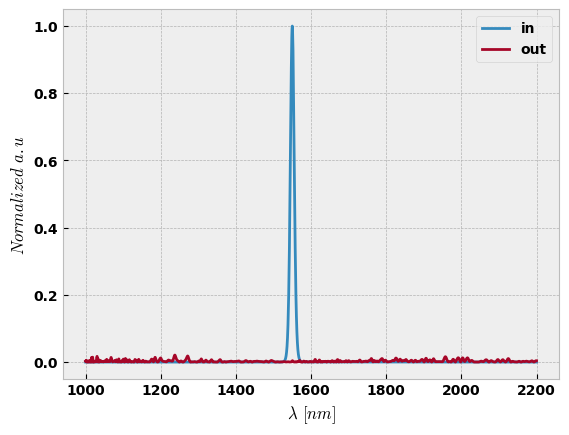

In [53]:
plt.plot(WL[iis]*1e9,10**(lIW[0]/10),label='in')
plt.plot(WL[iis]*1e9,10**(lIW[-1]/10),label='out')
plt.xlabel('$\lambda$ $[nm]$')
plt.ylabel('$Normalized$ $a.u$' )
#plt.ylim(-100,10)
plt.legend()

# Efectos de polarización.

En una fibra la cual presenta una falta de simetria cilindrica por deformaciones, se genera una birrefringenicia, la cual es caracterizada por,

$$B_m=\frac{|\beta_x-\beta_y|}{k_0}=|n_x-n_y|$$

Este parametro es conocido como modal birrefringence, dependiendo del tipo de fibra puede variar de forma aleatoria. 

# Intuición del fenomeno (XPM).

$$\mathbf{E}(\mathbf{r},t)=\frac{1}{2}(\hat{x}E_x+\hat{y}E_y)\text{exp}(-i\omega_0 t)+c.c$$

$$\mathbf{P}_{NL}(\mathbf{r},t)=\frac{1}{2}(\hat{x}P_x+\hat{y}P_y)\text{exp}(-i\omega_0 t)+c.c= \epsilon_0 \int_{-\infty}^{t} dt_{1}  \int_{-\infty}^{t} dt_{2} \int_{-\infty}^{t} dt_{3}\chi^{(3)}(t-t_1,t-t_2,t-t_3): \mathbf{E}(r,{t}_1) \mathbf{E}(r,{t}_2) \mathbf{E}(r,{t}_3)$$

Para medios isotropicos se sabe que,

$$\chi^{(3)}_{ijkl}=\chi^{(3)}_{xxyy}\delta_{ij}\delta_{kl}+\chi^{(3)}_{xyxy}\delta_{ik}\delta_{jl}+\chi^{(3)}_{xyyx}\delta_{il}\delta_{jk} \Rightarrow \chi^{(3)}_{xxxx}=\chi^{(3)}_{xxyy}+\chi^{(3)}_{xyxy}+\chi^{(3)}_{xyyx}$$


$$P_{x}=\frac{3 \epsilon_0}{4} \chi^{(3)}_{xxxx} \left[ \left( |E_x|^2+\frac{2}{3}|E_y|^2 \right)E_x +\frac{1}{3}(E_x*E_y)E_y \right]$$


$$P_{y}=\frac{3 \epsilon_0}{4} \chi^{(3)}_{xxxx} \left[ \left( |E_y|^2+\frac{2}{3}|E_x|^2 \right)E_y +\frac{1}{3}(E_xE_y^*)E_x \right]$$


La susceptibilidad,

$$\epsilon_j=\epsilon^{L}_{j}+\epsilon^{NL}_{j}=(n^{L}_{j}+\Delta n_{j})^{2}$$

Donde, 
$$\Delta n_{x}=\bar{n}_2 \left( |E_x|^2+\frac{2}{3}|E_y|^2 \right) $$

$$\Delta n_{y}=\bar{n}_2 \left( |E_y|^2+\frac{2}{3}|E_x|^2 \right) $$

Asumiendo que,

$$E_{j}(\mathbf{r},t)=F(x,y)A_{j}(z,t)\exp(i\beta_{0j}z)$$

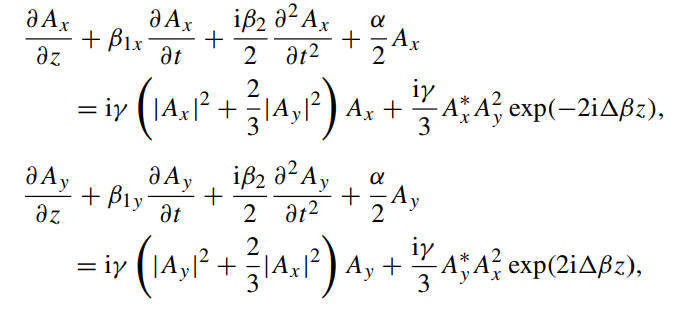

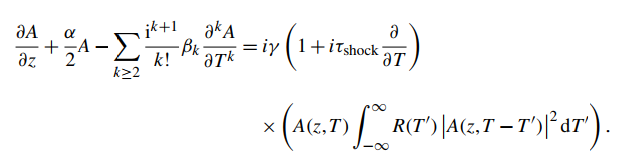